## **Responsi Praktikum Pengantar Data Mining**

Nama: Rifka Alya Damayanti\
NIM: 23/520088/PA/22339

#### **Studi Kasus: Analisis Sentimen terhadap Kebijakan MBKM**

Dalam beberapa tahun terakhir, kebijakan Merdeka Belajar Kampus Merdeka (MBKM) telah menjadi salah satu fokus utama dalam reformasi pendidikan tinggi di Indonesia. Kebijakan ini menuai berbagai tanggapan dari mahasiswa, dosen, dan masyarakat umum, yang sebagian besar diekspresikan melalui media sosial seperti X.
Sebagai seorang Data Scientist, Anda ditugaskan untuk melakukan analisis sentimen terhadap tweet-tweet yang membahas kebijakan MBKM. Anda akan menggunakan dataset hasil scraping X dengan kata kunci seperti "MBKM", "kampus merdeka", "merdeka belajar", "magang MBKM", dan istilah terkait lainnya.


In [1]:
!pip install nltk
!pip install WordCloud


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install Sastrawi


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## **Import Data**

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
import string

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)

In [55]:
# Read datasets
df1 = pd.read_csv("/Users/rifkaah/Downloads/Dataset Responsi (Train).csv")
df1

,full_text
0,@collegemenfess Semester 1: masih blm ada yg open Semester 2-3: lembaga dakwah prodi community development fakultas BEM prodi Semester 4-5: BEM prodi community development univ kampus mengajar (5) Semester 6: forum beasiswa univ Semester 7: forum beasiswa univ + msib + sempro Semester 8: end
1,Keanya cm prodi kampus ku yg ttp ngasi tugas ke mahasiswanya pdhl lagi MAGANG??? bjrot lah pdhl w ikut msib yg harusnya FULL konversi tp ttp harus kuliah dan dikasi tugas????
2,Hai #SobatSukses BSI Career Selamat &amp; sukses untuk mahasiswa/i terbaik dari Universitas Bina Sarana Informatika yang berhasil lolos pada program Magang &amp; Studi Independen Bersertifikat (MSIB) Kampus Merdeka Batch 6 Tahun 2024. https://t.co/ot00ovVQCN
3,Pengen cepet selesai kampus mengajar
4,kk alumni yg ke Taiwan tahun2 lalu boleh tau gaa bawa koper brapa &amp; uk brpa ajaa any tips kah buat koper atau per-packing an ini tia IISMA!
...,...
5735,Yakinin gue kalo anak UT bisa ikutan program kampus merdeka entah itu magang/pertukaran mahasiswa
5736,@1223_gall bole DM tentang kampus mengajar ga kak?
5737,@why_you_lie_r @sukajembatan Hallo kak Boleh tanya-tanya terkait magang msib di SIER?
5738,@romeogadungan MSIB ngasih kesempatan mahasiswanya buat terjun lgsg ke dunia industri ngasih pengalaman magang di perusahaan2 pemerintah sampe yg non-profit


## **Pemahaman Data (EDA Ringan)**

### **Distribusi Panjang Teks**

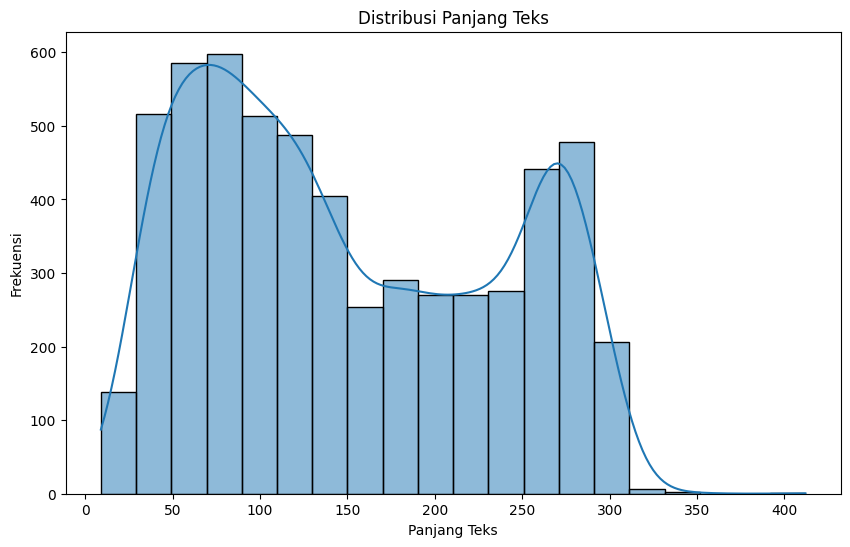

In [57]:
df_vis = df1.copy()
df_vis['num'] = df_vis['full_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df_vis['num'], bins=20, kde=True)
plt.title('Distribusi Panjang Teks')
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.show()

**Interpretasi**

Histogram distribusi panjang teks menunjukkan pola bimodal, dengan dua puncak utama di sekitar panjang 50–100 dan 250–300 karakter, yang tandakan adanya dua kelompok teks berbeda dalam dataset, kemungkinan teks pendek seperti komentar dan teks panjang seperti narasi atau caption. Frekuensi teks menurun drastis setelah 300 karakter, menunjukkan sebagian besar teks tidak terlalu panjang.

## **Preprocessing**

In [46]:
def clean_text(text):
    # Ubah ke lowercase dan strip whitespace
    text = text.lower().strip()
    # Menghapus username
    text = re.sub(r'@[^\s]+', '', text)
    # Menghapus kata 'rt'
    text = re.sub(r'\brt\b', '', text)
    # Menghapus URL
    text = re.sub(r'((www\S+)|(http\S+))', ' ', text)
    # Menghapus angka
    text = re.sub(r'\d+', ' ', text)
    # Menghapus karakter non-ASCII
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Menghapus tab, new line, dan backslash
    text = text.replace('\t', ' ').replace('\n', ' ').replace('\\', '')
    # Mengganti ellipsis dengan spasi
    text = re.sub(r'\.\.\.', ' ', text)
    # Menghapus punctuation kecuali tanda titik
    text = re.sub(r'\.\.', '', text)
    # Mengganti titik dengan spasi jika diikuti oleh huruf
    text = re.sub(r'\.', ' ', text)
    # Menghapus extra whitespace
    text = ' '.join(text.split())
    # Menghapus ( / )
    text = re.sub(r'( / )', '', text)
    # Menghapus ()
    text = text.replace('()', '')
    # Menghapus hastag
    text = re.sub(r'#\w+', '', text)
    # Hapus ;
    text = text.replace(';', '')
    #  Punctuation Removal: Menghapus tanda baca (seperti titik, koma, tanda seru, tanda tanya, dan titik koma)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text


Selanjutnya, akan dilakukan pembersihan text dengan fungsi clean_text. Fungsi clean_text bertujuan untuk membersihkan dan menormalkan teks mentah agar siap diproses lebih lanjut dalam analisis teks atau pemodelan machine learning. Fungsi ini menghapus elemen-elemen yang tidak relevan seperti mention (@username), retweet (rt), URL, angka, karakter non-ASCII, tagar, simbol-simbol khusus, dan tanda baca, serta mengubah semua huruf menjadi huruf kecil. Selain itu, fungsi ini juga merapikan spasi berlebih, menghapus karakter tabulasi dan baris baru, serta memastikan teks yang dihasilkan bersih dan konsisten untuk memudahkan analisis lanjutan seperti tokenisasi, vektorisasi, atau klasifikasi.

In [47]:
df2 = df1.copy()
df2['clean'] = df1['full_text'].apply(clean_text)

In [48]:
df2

,full_text,clean
0,@collegemenfess Semester 1: masih blm ada yg open Semester 2-3: lembaga dakwah prodi community development fakultas BEM prodi Semester 4-5: BEM prodi community development univ kampus mengajar (5) Semester 6: forum beasiswa univ Semester 7: forum beasiswa univ + msib + sempro Semester 8: end,semester masih blm ada yg open semester lembaga dakwah prodi community development fakultas bem prodi semester bem prodi community development univ kampus mengajar semester forum beasiswa univ semester forum beasiswa univ msib sempro semester end
1,Keanya cm prodi kampus ku yg ttp ngasi tugas ke mahasiswanya pdhl lagi MAGANG??? bjrot lah pdhl w ikut msib yg harusnya FULL konversi tp ttp harus kuliah dan dikasi tugas????,keanya cm prodi kampus ku yg ttp ngasi tugas ke mahasiswanya pdhl lagi magang bjrot lah pdhl w ikut msib yg harusnya full konversi tp ttp harus kuliah dan dikasi tugas
2,Hai #SobatSukses BSI Career Selamat &amp; sukses untuk mahasiswa/i terbaik dari Universitas Bina Sarana Informatika yang berhasil lolos pada program Magang &amp; Studi Independen Bersertifikat (MSIB) Kampus Merdeka Batch 6 Tahun 2024. https://t.co/ot00ovVQCN,hai bsi career selamat amp sukses untuk mahasiswai terbaik dari universitas bina sarana informatika yang berhasil lolos pada program magang amp studi independen bersertifikat msib kampus merdeka batch tahun
3,Pengen cepet selesai kampus mengajar,pengen cepet selesai kampus mengajar
4,kk alumni yg ke Taiwan tahun2 lalu boleh tau gaa bawa koper brapa &amp; uk brpa ajaa any tips kah buat koper atau per-packing an ini tia IISMA!,kk alumni yg ke taiwan tahun lalu boleh tau gaa bawa koper brapa amp uk brpa ajaa any tips kah buat koper atau perpacking an ini tia iisma
...,...,...
5735,Yakinin gue kalo anak UT bisa ikutan program kampus merdeka entah itu magang/pertukaran mahasiswa,yakinin gue kalo anak ut bisa ikutan program kampus merdeka entah itu magangpertukaran mahasiswa
5736,@1223_gall bole DM tentang kampus mengajar ga kak?,bole dm tentang kampus mengajar ga kak
5737,@why_you_lie_r @sukajembatan Hallo kak Boleh tanya-tanya terkait magang msib di SIER?,hallo kak boleh tanyatanya terkait magang msib di sier
5738,@romeogadungan MSIB ngasih kesempatan mahasiswanya buat terjun lgsg ke dunia industri ngasih pengalaman magang di perusahaan2 pemerintah sampe yg non-profit,msib ngasih kesempatan mahasiswanya buat terjun lgsg ke dunia industri ngasih pengalaman magang di perusahaan pemerintah sampe yg nonprofit


In [49]:
df2['clean'].unique()

array(['semester  masih blm ada yg open semester   lembaga dakwah prodi community development fakultas bem prodi semester   bem prodi community development univ kampus mengajar   semester  forum beasiswa univ semester  forum beasiswa univ  msib  sempro semester  end',
       'keanya cm prodi kampus ku yg ttp ngasi tugas ke mahasiswanya pdhl lagi magang bjrot lah pdhl w ikut msib yg harusnya full konversi tp ttp harus kuliah dan dikasi tugas',
       'hai  bsi career selamat amp sukses untuk mahasiswai terbaik dari universitas bina sarana informatika yang berhasil lolos pada program magang amp studi independen bersertifikat msib kampus merdeka batch tahun',
       ..., 'hallo kak boleh tanyatanya terkait magang msib di sier',
       'msib ngasih kesempatan mahasiswanya buat terjun lgsg ke dunia industri ngasih pengalaman magang di perusahaan pemerintah sampe yg nonprofit',
       'kebetulan aku ada pengalaman magang msib  kerja di digital marketing agency tapi belum lulus'],
      shape

Untuk memastikan hasil analisis teks lebih bermakna dan fokus pada informasi penting, dilakukan tahap pra-pemrosesan lanjutan dengan menghapus kata-kata yang tidak memiliki makna signifikan. 

In [50]:
# kamus 1
sl1 = {"@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "g" : "tidak", "w" : "aku", "yy" : "yang", "yg" : "yang", "tetannga" : "tetangga"}

# kamus2
sl2 = pd.read_csv("https://raw.githubusercontent.com/haryoa/indo-collex/main/dict/inforformal-formal-Indonesian-dictionary.tsv", sep="\t")
sl2.set_index("informal", drop=True, inplace=True)
sl2 = sl2.to_dict()["formal"]
sl2

# kamus 3
sl3 = pd.read_csv("https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt", sep="\t", header=None)
sl3.set_index(0, drop=True, inplace=True)
sl3 = sl3.to_dict()[1]

# Gabungkan semua kamus slang words
sl_word = {**sl1, **sl2, **sl3}

print(dict(list(sl_word.items())[1:10]))

{'abis': 'habis', 'ad': 'ada', 'adlh': 'adalah', 'afaik': 'as far as i know', 'ahaha': 'haha', 'aj': 'saja', 'ajep-ajep': 'dunia gemerlap', 'ak': 'saya', 'akika': 'aku'}


In [51]:
# kamus 1: sastrawi
factory = StopWordRemoverFactory()
sw_id1 = factory.get_stop_words()

# kamus 2
sw_id2 = pd.read_csv("https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt",header=None)
sw_id2 = list(sw_id1[0])

# kamus 3
sw_id3 = ['kalau', 'terus', 'iya', 'lah', 'jadi', 'mah', 'an', 'sih', 'pak', 'masa', 'apa', 'mau', 'sama', 'lebih', 'bahkan', 'buat', 'nya', 'aku', 'awal', 'deh', 'kakak', 'sok', 'akang', 'om', 'as', 'ngab']

# Gabungkan
sw_id = sw_id1 + sw_id2 + sw_id3

sw_id[:20]

['yang',
 'untuk',
 'pada',
 'ke',
 'para',
 'namun',
 'menurut',
 'antara',
 'dia',
 'dua',
 'ia',
 'seperti',
 'jika',
 'jika',
 'sehingga',
 'kembali',
 'dan',
 'tidak',
 'ini',
 'karena']

In [52]:
# Fungsi menghapus stopword
def stopwords_removal(words,stopword):
    return [word for word in words if word not in stopword]

def preprocess_text(text, slang_words = sl_word, sw = sw_id):
    # SlangWords Handling
    text = ' '.join([slang_words.get(word, word) for word in text.split()])

    # Stemming
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = stemmer.stem(text)

    # Stop Words Removal
    text = text.split()
    text = " ".join(stopwords_removal(text, sw))

    return text

In [14]:
# Terapkan pada dataset
df2_pre = df2.copy()
df2_pre['clean'] = df2_pre['clean'].apply(preprocess_text)

# Sebelum, sesudah cleaning, dan sesudah preprocessing
df2_pre

,full_text,clean
0,@collegemenfess Semester 1: masih blm ada yg open Semester 2-3: lembaga dakwah prodi community development fakultas BEM prodi Semester 4-5: BEM prodi community development univ kampus mengajar (5) Semester 6: forum beasiswa univ Semester 7: forum beasiswa univ + msib + sempro Semester 8: end,semester open semester lembaga dakwah prodi community development fakultas badan eksekutif mahasiswa prodi semester badan eksekutif mahasiswa prodi community development univ kampus ajar semester forum beasiswa univ semester forum beasiswa univ msib sempro semester end
1,Keanya cm prodi kampus ku yg ttp ngasi tugas ke mahasiswanya pdhl lagi MAGANG??? bjrot lah pdhl w ikut msib yg harusnya FULL konversi tp ttp harus kuliah dan dikasi tugas????,keanya cuma prodi kampus ku tetap beri tugas mahasiswa padahal magang bjrot padahal ikut msib full konversi tetap kuliah kasi tugas
2,Hai #SobatSukses BSI Career Selamat &amp; sukses untuk mahasiswa/i terbaik dari Universitas Bina Sarana Informatika yang berhasil lolos pada program Magang &amp; Studi Independen Bersertifikat (MSIB) Kampus Merdeka Batch 6 Tahun 2024. https://t.co/ot00ovVQCN,hai bsi career selamat amp sukses mahasiswa baik universitas bina sarana informatika hasil lolos program magang amp studi independen sertifikat msib kampus merdeka batch tahun
3,Pengen cepet selesai kampus mengajar,cepat selesai kampus ajar
4,kk alumni yg ke Taiwan tahun2 lalu boleh tau gaa bawa koper brapa &amp; uk brpa ajaa any tips kah buat koper atau per-packing an ini tia IISMA!,alumni taiwan tahun lalu tahu bawa koper berapa amp uk brpa any tips koper perpacking tia iisma
...,...,...
5735,Yakinin gue kalo anak UT bisa ikutan program kampus merdeka entah itu magang/pertukaran mahasiswa,yakinin anak ut ikut program kampus merdeka entah magangpertukaran mahasiswa
5736,@1223_gall bole DM tentang kampus mengajar ga kak?,dm kampus ajar kak
5737,@why_you_lie_r @sukajembatan Hallo kak Boleh tanya-tanya terkait magang msib di SIER?,halo kak tanyatanya kait magang msib sier
5738,@romeogadungan MSIB ngasih kesempatan mahasiswanya buat terjun lgsg ke dunia industri ngasih pengalaman magang di perusahaan2 pemerintah sampe yg non-profit,msib beri sempat mahasiswa terjun langsung dunia industri beri alam magang usaha perintah nonprofit


## **Labeling Sentimen**

Data di bawah adalah data yang telah diberikan perlakuan labeling secara manual.

In [53]:
%pip install openpyxl

# Membaca file Excel
df_label = pd.read_excel("/Users/rifkaah/Downloads/PDMPDMPDM(1).xlsx")
df_label


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,full_text,LABEL
0,@collegemenfess Semester 1: masih blm ada yg open Semester 2-3: lembaga dakwah prodi community development fakultas BEM prodi Semester 4-5: BEM prodi community development univ kampus mengajar (5) Semester 6: forum beasiswa univ Semester 7: forum beasiswa univ + msib + sempro Semester 8: end,NT
1,Keanya cm prodi kampus ku yg ttp ngasi tugas ke mahasiswanya pdhl lagi MAGANG??? bjrot lah pdhl w ikut msib yg harusnya FULL konversi tp ttp harus kuliah dan dikasi tugas????,N
2,Hai #SobatSukses BSI Career Selamat &amp sukses untuk mahasiswa/i terbaik dari Universitas Bina Sarana Informatika yang berhasil lolos pada program Magang &amp Studi Independen Bersertifikat (MSIB) Kampus Merdeka Batch 6 Tahun 2024. https://t.co/ot00ovVQCN,P
3,Pengen cepet selesai kampus mengajar,N
4,kk alumni yg ke Taiwan tahun2 lalu boleh tau gaa bawa koper brapa &amp uk brpa ajaa any tips kah buat koper atau per-packing an ini tia IISMA!,NT
...,...,...
5735,Yakinin gue kalo anak UT bisa ikutan program kampus merdeka entah itu magang/pertukaran mahasiswa,P
5736,@1223_gall bole DM tentang kampus mengajar ga kak?,NT
5737,@why_you_lie_r @sukajembatan Hallo kak Boleh tanya-tanya terkait magang msib di SIER?,NT
5738,@romeogadungan MSIB ngasih kesempatan mahasiswanya buat terjun lgsg ke dunia industri ngasih pengalaman magang di perusahaan2 pemerintah sampe yg non-profit,P


### **Ambil Kolom LABEL saja**

In [16]:
label = df_label['LABEL']
label

0       NT
1        N
2        P
3        N
4       NT
        ..
5735     P
5736    NT
5737    NT
5738     P
5739    NT
Name: LABEL, Length: 5740, dtype: object

### **Gabungkan Label ke Data yang telah dipreprocess**

In [17]:
df2_pre['LABEL'] = label
df2_pre.head()

,full_text,clean,LABEL
0,@collegemenfess Semester 1: masih blm ada yg open Semester 2-3: lembaga dakwah prodi community development fakultas BEM prodi Semester 4-5: BEM prodi community development univ kampus mengajar (5) Semester 6: forum beasiswa univ Semester 7: forum beasiswa univ + msib + sempro Semester 8: end,semester open semester lembaga dakwah prodi community development fakultas badan eksekutif mahasiswa prodi semester badan eksekutif mahasiswa prodi community development univ kampus ajar semester forum beasiswa univ semester forum beasiswa univ msib sempro semester end,NT
1,Keanya cm prodi kampus ku yg ttp ngasi tugas ke mahasiswanya pdhl lagi MAGANG??? bjrot lah pdhl w ikut msib yg harusnya FULL konversi tp ttp harus kuliah dan dikasi tugas????,keanya cuma prodi kampus ku tetap beri tugas mahasiswa padahal magang bjrot padahal ikut msib full konversi tetap kuliah kasi tugas,N
2,Hai #SobatSukses BSI Career Selamat &amp; sukses untuk mahasiswa/i terbaik dari Universitas Bina Sarana Informatika yang berhasil lolos pada program Magang &amp; Studi Independen Bersertifikat (MSIB) Kampus Merdeka Batch 6 Tahun 2024. https://t.co/ot00ovVQCN,hai bsi career selamat amp sukses mahasiswa baik universitas bina sarana informatika hasil lolos program magang amp studi independen sertifikat msib kampus merdeka batch tahun,P
3,Pengen cepet selesai kampus mengajar,cepat selesai kampus ajar,N
4,kk alumni yg ke Taiwan tahun2 lalu boleh tau gaa bawa koper brapa &amp; uk brpa ajaa any tips kah buat koper atau per-packing an ini tia IISMA!,alumni taiwan tahun lalu tahu bawa koper berapa amp uk brpa any tips koper perpacking tia iisma,NT


### **Drop Kolom full_text**

In [ ]:
df2_pre = df2_pre.drop(columns=['full_text'])

In [ ]:
df2_pre

,clean,LABEL
0,semester open semester lembaga dakwah prodi community development fakultas badan eksekutif mahasiswa prodi semester badan eksekutif mahasiswa prodi community development univ kampus ajar semester forum beasiswa univ semester forum beasiswa univ msib sempro semester end,NT
1,keanya cuma prodi kampus ku tetap beri tugas mahasiswa padahal magang bjrot padahal ikut msib full konversi tetap kuliah kasi tugas,N
2,hai bsi career selamat amp sukses mahasiswa baik universitas bina sarana informatika hasil lolos program magang amp studi independen sertifikat msib kampus merdeka batch tahun,P
3,cepat selesai kampus ajar,N
4,alumni taiwan tahun lalu tahu bawa koper berapa amp uk brpa any tips koper perpacking tia iisma,NT
...,...,...
5735,yakinin anak ut ikut program kampus merdeka entah magangpertukaran mahasiswa,P
5736,dm kampus ajar kak,NT
5737,halo kak tanyatanya kait magang msib sier,NT
5738,msib beri sempat mahasiswa terjun langsung dunia industri beri alam magang usaha perintah nonprofit,P


### **Drop Baris yang Mengandung LABEL X**

In [ ]:
df2_pre = df2_pre[df2_pre['LABEL'] != 'X']
df2_pre.reset_index(drop=True, inplace=True)

Beberapa baris data diketahui mengandung informasi yang kurang relevan terhadap sentimen terhadap program MBKM, sehingga baris-baris tersebut dihapus untuk memastikan fokus analisis tetap pada data yang sesuai dan bermakna.

## **EDA Sebelum Modelling**

### **Distribusi Sentimen**

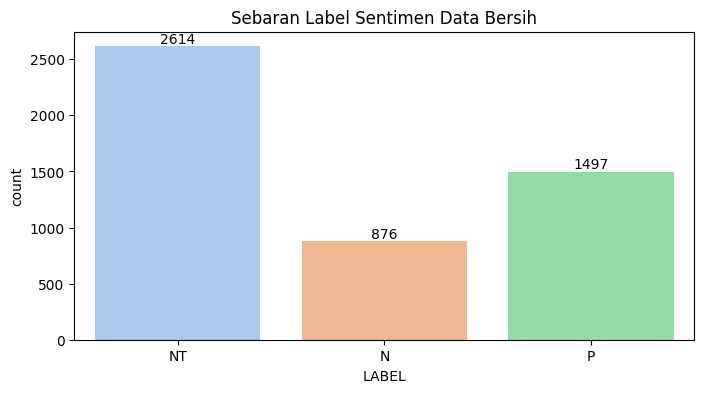

In [81]:
# Membuat plot
plt.figure(figsize=(8,4))
ax = sns.countplot(x='LABEL', data=df2_pre, palette='pastel')
plt.title('Sebaran Label Sentimen Data Bersih')
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.show()

**Interpretasi**

Grafik tersebut menunjukkan sebaran label sentimen dalam data yang telah dibersihkan, terdiri dari tiga kategori: NT (Netral), N (Negatif), dan P (Positif). Dari total data, label netral (NT) mendominasi dengan 2.614 data, diikuti oleh sentimen positif (P) sebanyak 1.497 data, dan yang paling sedikit adalah sentimen negatif (N) sebanyak 876 data. Ketimpangan jumlah ini mengindikasikan bahwa dataset tidak seimbang, sehingga perlu penanganan khusus seperti resampling agar model tidak bias terhadap kelas mayoritas saat dilatih.

## **Modelling**

menggunakan df2_pre yang telah disimpan dalam file directory

In [102]:
df_mod = pd.read_csv("/Users/rifkaah/Desktop/college/SEMESTER 4/(Prak) PDM/responsi/df2_pre.csv")
df_mod.head()

,clean,LABEL
0,semester open semester lembaga dakwah prodi community development fakultas badan eksekutif mahasiswa prodi semester badan eksekutif mahasiswa prodi community development univ kampus ajar semester forum beasiswa univ semester forum beasiswa univ msib sempro semester end,NT
1,keanya cuma prodi kampus ku tetap beri tugas mahasiswa padahal magang bjrot padahal ikut msib full konversi tetap kuliah kasi tugas,N
2,hai bsi career selamat amp sukses mahasiswa baik universitas bina sarana informatika hasil lolos program magang amp studi independen sertifikat msib kampus merdeka batch tahun,P
3,cepat selesai kampus ajar,N
4,alumni taiwan tahun lalu tahu bawa koper berapa amp uk brpa any tips koper perpacking tia iisma,NT


In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('punkt')
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation

kf = KFold(n_splits=5, random_state = 42, shuffle = True)

[nltk_data] Downloading package punkt to /Users/rifkaah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **Split Data Train dan Data Test**

In [104]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_mod['clean'])
y = df_mod['LABEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Logistic Regression dengan Borderline-SMOTE**

Logistic Regression adalah algoritma klasifikasi linier yang memodelkan probabilitas suatu data termasuk ke dalam kelas tertentu menggunakan fungsi logistik. Model ini mencari garis atau bidang pemisah terbaik yang memaksimalkan kemungkinan pemisahan antar kelas.

Borderline-SMOTE dipilih untuk mengatasi masalah ketidakseimbangan kelas, dengan cara membuat data sintetis pada titik-titik minoritas yang berada di dekat batas keputusan (decision boundary). Logistic Regression sensitif terhadap data yang tidak seimbang karena akan cenderung memilih kelas mayoritas, sehingga dengan menambahkan sampel minoritas di wilayah penting (borderline), model dapat lebih adil dalam membuat prediksi.


In [105]:
from imblearn.over_sampling import BorderlineSMOTE
borderline_smote = BorderlineSMOTE(random_state=11)
X_train_res, y_train_res = borderline_smote.fit_resample(X_train, y_train)

lr_model = LogisticRegression(max_iter=12)
lr_model.fit(X_train_res, y_train_res)
y_pred_lr = lr_model.predict(X_test)

print("Random Under-Sampling")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test,y_pred_lr))

Random Under-Sampling
              precision    recall  f1-score   support

           N       0.40      0.55      0.46       165
          NT       0.72      0.58      0.64       524
           P       0.53      0.59      0.56       309

    accuracy                           0.58       998
   macro avg       0.55      0.57      0.55       998
weighted avg       0.61      0.58      0.58       998

Accuracy: 0.5771543086172345


### **SVC dengan Random Under-Sampling**










SVC adalah metode klasifikasi berbasis margin yang mencari hyperplane (batas) terbaik yang memisahkan kelas dengan margin maksimum. Model ini sangat efektif dalam ruang berdimensi tinggi dan dapat menggunakan kernel untuk menangani non-linearitas.

SVC bekerja optimal jika data seimbang. Random Under-Sampling mengurangi jumlah sampel dari kelas mayoritas secara acak agar jumlahnya mendekati kelas minoritas. Ini membuat margin pemisah yang dihasilkan oleh SVC lebih representatif karena tidak bias terhadap kelas yang dominan. Pendekatan ini juga lebih ringan secara komputasi dibanding oversampling, yang cocok karena SVC relatif mahal secara waktu pelatihan.

In [106]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=11)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

svc_model = SVC(random_state = 100)
svc_model.fit(X_train_res, y_train_res)
y_pred_svc = svc_model.predict(X_test)

print("Random Under-Sampling")
print(classification_report(y_test, y_pred_svc))
print("Accuracy:", accuracy_score(y_test,y_pred_svc))

Random Under-Sampling
              precision    recall  f1-score   support

           N       0.36      0.75      0.49       165
          NT       0.75      0.50      0.60       524
           P       0.55      0.53      0.54       309

    accuracy                           0.55       998
   macro avg       0.55      0.60      0.54       998
weighted avg       0.62      0.55      0.56       998

Accuracy: 0.5541082164328658


### **Random Forest dengan Borderline-SMOTE**

Random Forest adalah algoritma ensemble yang membentuk banyak decision tree pada subset data acak, lalu mengambil hasil prediksi mayoritas. Model ini kuat terhadap overfitting dan mampu menangkap hubungan non-linear antar fitur.

Walaupun Random Forest relatif tahan terhadap ketidakseimbangan data, penggunaan Borderline-SMOTE membantu lebih jauh dalam meningkatkan performa prediksi pada kelas minoritas, terutama di kasus di mana kelas minoritas sering salah diklasifikasi. Dengan menambahkan data sintetis di area kritis (borderline), Random Forest bisa membangun pohon keputusan yang lebih akurat dan seimbang.



In [109]:
# Membuat dan melatih model RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
borderline_smote = BorderlineSMOTE(random_state=11)
X_train_res, y_train_res = borderline_smote.fit_resample(X_train, y_train)
rf_model.fit(X_train_res, y_train_res)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classifier")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Classifier
              precision    recall  f1-score   support

           N       0.56      0.42      0.48       165
          NT       0.66      0.78      0.71       524
           P       0.61      0.49      0.54       309

    accuracy                           0.63       998
   macro avg       0.61      0.57      0.58       998
weighted avg       0.63      0.63      0.62       998

Accuracy: 0.6322645290581163


## **Evaluasi**

Pada section evaluasi, dipilih metrik Akurasi dan F1-Score. Akurasi dan F1-score digunakan karena keduanya saling melengkapi dalam mengevaluasi performa model klasifikasi. Akurasi menunjukkan seberapa sering model membuat prediksi yang benar secara keseluruhan, sedangkan F1-score memberikan gambaran seimbang antara kemampuan model dalam mengenali kelas positif dengan benar (recall) dan ketepatannya dalam memprediksi kelas tersebut (precision). Penggunaan F1-score menjadi penting terutama ketika data tidak seimbang, agar performa model terhadap kelas minoritas tetap diperhatikan.

In [110]:
# Akurasi dan F1-score untuk Logistic Regression# Akurasi dan F1-score untuk Logistic Regression# Akurasi dan F1-score untuk Logistic Regression
print("Akurasi Logistic Regression:", accuracy_score(y_test, y_pred_lr))
print("F1-score Logistic Regression:", classification_report(y_test, y_pred_lr, output_dict=True)['macro avg']['f1-score'])
# Akurasi dan F1-score untuk SVC
print("Akurasi SVC:", accuracy_score(y_test, y_pred_svc))
print("F1-score SVC:", classification_report(y_test, y_pred_svc, output_dict=True)['macro avg']['f1-score'])
# Akurasi dan F1-score untuk Random Forest      
print("Akurasi Random Forest:", accuracy_score(y_test, y_pred_rf))
print("F1-score Random Forest:", classification_report(y_test, y_pred_rf, output_dict=True)['macro avg']['f1-score'])

Akurasi Logistic Regression: 0.5771543086172345
F1-score Logistic Regression: 0.5526132540308727
Akurasi SVC: 0.5541082164328658
F1-score SVC: 0.5433326141295653
Akurasi Random Forest: 0.6322645290581163
F1-score Random Forest: 0.5794557598546254


**Interpretasi**

Model Random Forest adalah yang terbaik di antara model lainnya.

Akurasi tertinggi dimiliki oleh Random Forest: 0.632, dibandingkan Logistic Regression (0.580) dan SVC (0.554). F1-score tertinggi juga dimiliki oleh Random Forest: 0.579, dibandingkan Logistic Regression (0.557) dan SVC (0.543).

Karena F1-score mempertimbangkan precision dan recall secara seimbang, metrik ini menjadi penting terutama apabila terdapat ketidakseimbangan jumlah antar kelas dalam data. Oleh karena itu, dengan nilai F1-score tertinggi yang dimiliki oleh model Random Forest, dapat disimpulkan bahwa **model Random Forest merupakan model yang paling optimal** dibandingkan dengan model lainnya.

## **Visualisasi**

In [20]:
def plot_wordcloud_and_frequency(df, text_column, label_column, stopwords = sw_id, num_word = 10):
    labels = df[label_column].unique()
    num_cols = 2

    for label in labels:
        fig, axes = plt.subplots(1, num_cols, figsize=(12, 6))

        # Filter text by label
        text = " ".join(df[df[label_column] == label][text_column])

        # Generate wordcloud with a colormap
        wordcloud = WordCloud(width=400, height=400,
                              background_color='white',
                              stopwords=stopwords,
                              min_font_size=10,
                              colormap='viridis').generate(text)

        # Display wordcloud
        axes[0].imshow(wordcloud)
        axes[0].axis("off")
        axes[0].set_title(f'WordCloud - {label}')

        # Compute word frequency
        text_data = df[df[label_column] == label][text_column]
        word_frequency = text_data.str.split(expand=True).stack().value_counts()
        freq = word_frequency.head(num_word) # adjust numbers of word

        # Display word frequency bar plot with a color palette
        sns.barplot(x=freq.values, y=freq.index, ax=axes[1], palette="muted")
        axes[1].set_title(f'Word Frequency - {label}')
        axes[1].set_xlabel('Count')
        for p in axes[1].patches:
            axes[1].annotate("{:.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + .5), ha='left', va='center')

        plt.tight_layout()
        plt.show()

In [75]:
df2_pre

,clean,LABEL
0,semester open semester lembaga dakwah prodi community development fakultas badan eksekutif mahasiswa prodi semester badan eksekutif mahasiswa prodi community development univ kampus ajar semester forum beasiswa univ semester forum beasiswa univ msib sempro semester end,NT
1,keanya cuma prodi kampus ku tetap beri tugas mahasiswa padahal magang bjrot padahal ikut msib full konversi tetap kuliah kasi tugas,N
2,hai bsi career selamat amp sukses mahasiswa baik universitas bina sarana informatika hasil lolos program magang amp studi independen sertifikat msib kampus merdeka batch tahun,P
3,cepat selesai kampus ajar,N
4,alumni taiwan tahun lalu tahu bawa koper berapa amp uk brpa any tips koper perpacking tia iisma,NT
...,...,...
4982,yakinin anak ut ikut program kampus merdeka entah magangpertukaran mahasiswa,P
4983,dm kampus ajar kak,NT
4984,halo kak tanyatanya kait magang msib sier,NT
4985,msib beri sempat mahasiswa terjun langsung dunia industri beri alam magang usaha perintah nonprofit,P


In [76]:
df2_pre = df2_pre[df2_pre['LABEL'] != 'X']
df2_pre.reset_index(drop=True, inplace=True)

### **WordCloud**

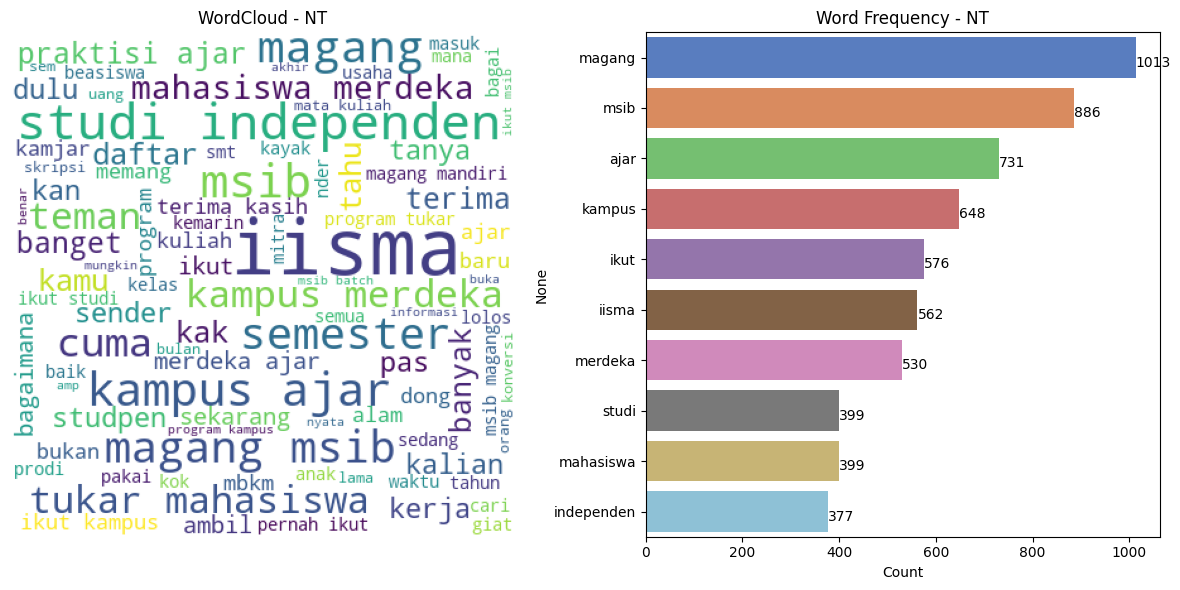

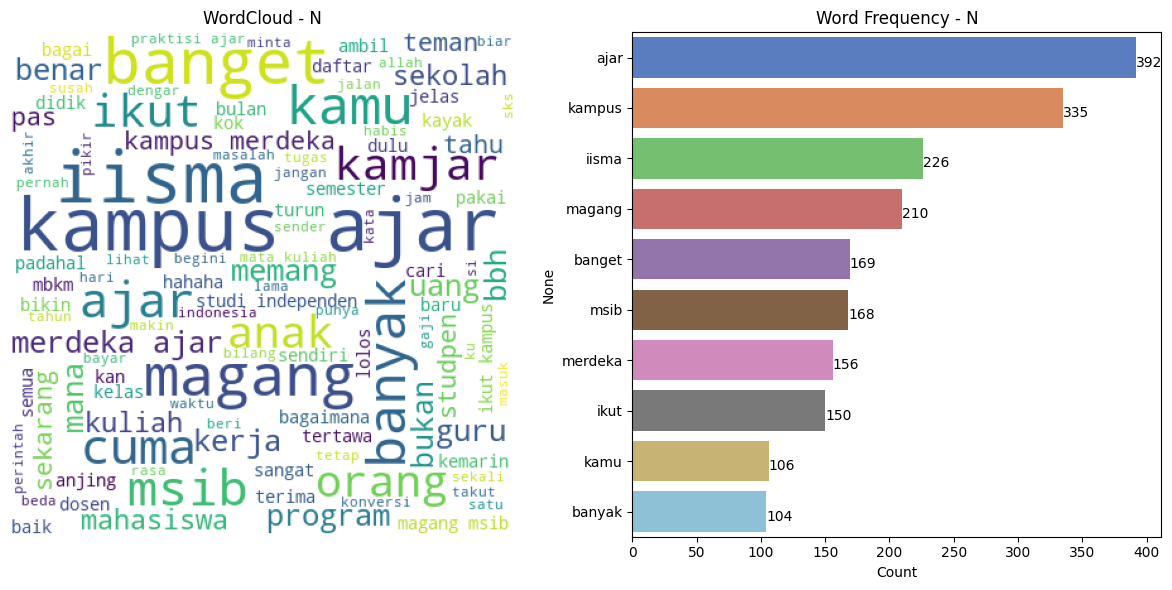

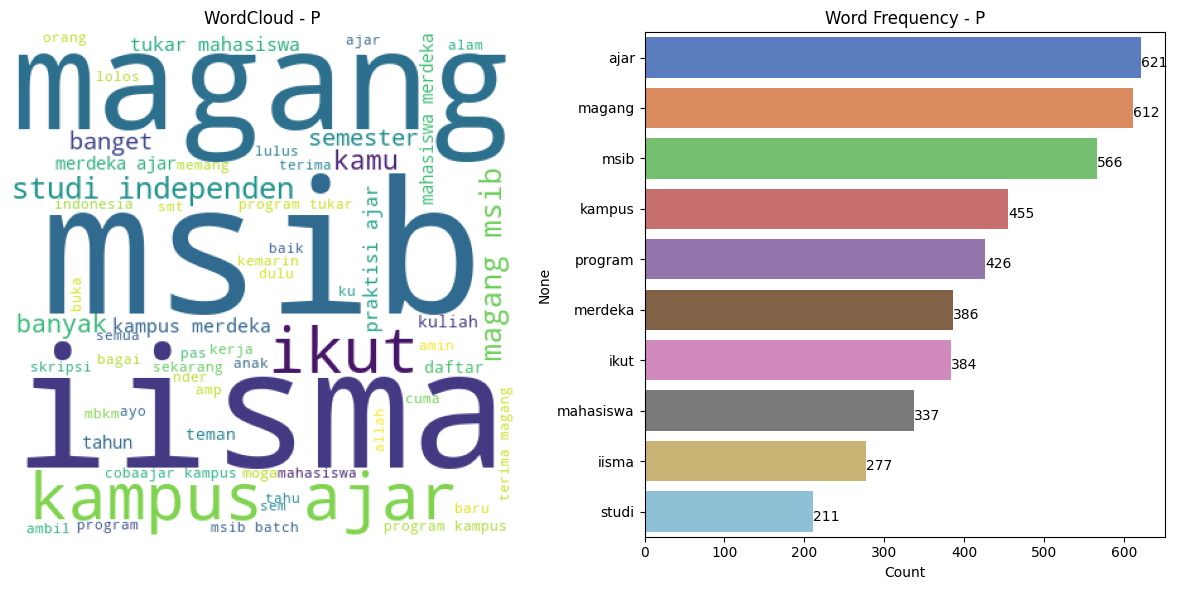

In [26]:
plot_wordcloud_and_frequency(df2_pre, 'clean', 'LABEL', sw_id, 10)

### **Interpretasi**

#### **Word Cloud Sentimen Netral**

1. **magang**: Kata paling sering muncul. Menunjukkan bahwa banyak pengguna membahas program magang tanpa ekspresi sentimen kuat. Kata ini bisa bersifat informatif, seperti jadwal, pendaftaran, atau pengalaman umum.

2. **msib**: Akronim dari *Magang dan Studi Independen Bersertifikat*. Banyak disebut dalam konteks netral, mungkin hanya menyebut nama program.

3. **ajar**: Berarti kegiatan pembelajaran, kemungkinan berkaitan dengan tugas atau pengajar dalam program MBKM.

4. **kampus**: Sering digunakan sebagai rujukan tempat kegiatan atau institusi asal peserta program.

5. **ikut**: Digunakan untuk menyatakan keterlibatan atau partisipasi dalam program MBKM, secara umum.

6. **iisma**: “IISMA” (Indonesian International Student Mobility Awards), yang merupakan salah satu program MKBM. Kata ini bisa jadi bersifat informatif. 

7. **merdeka**: Merujuk pada “Kampus Merdeka”, bagian dari nama program, muncul dalam konteks deskriptif.

8. **studi**: Umum digunakan dalam konteks *studi independen*, sebagai salah satu skema MBKM.

9. **mahasiswa**: Menandakan subjek utama yang terlibat dalam percakapan atau pelaksanaan program.

10. **independen**: Berkaitan langsung dengan program *Studi Independen*, disebut secara netral dalam konteks penyebutan skema.

Setiap kata muncul dalam konteks informatif atau deskriptif, tanpa muatan emosi yang kuat, sesuai dengan kategori sentimen **netral**.


#### **Word Cloud Sentimen Negatif**

1. **ajar**: Kata paling sering muncul. Kemungkinan terkait keluhan tentang metode mengajar, beban tugas, atau kualitas pengajaran.

2. **kampus**: Menunjukkan bahwa topik keluhan atau ketidakpuasan sering berkaitan langsung dengan kebijakan atau sistem kampus.

3. **iisma**: Program *Indonesian International Student Mobility Awards* muncul cukup dominan, kemungkinan karena pengalaman yang kurang menyenangkan atau kendala administratif.

4. **magang**:  Dapat merujuk pada pengalaman magang yang tidak sesuai harapan, beban kerja tinggi, atau permasalahan komunikasi dengan tempat magang.

5. **banget**: Kata intensifier (penguat), biasanya digunakan untuk menekankan keluhan, misalnya “susah banget”, “ribet banget”, dll.

6. **msib**: Program *Magang dan Studi Independen Bersertifikat* juga sering disebut, berpotensi dalam konteks kekecewaan terhadap alur, pembimbing, atau teknis pelaksanaan.

7. **merdeka**: Terkait dengan “Kampus Merdeka”, mungkin dipakai dalam konteks kritis terhadap kebijakan yang dirasa kurang menguntungkan.

8. **ikut**: Mengacu pada partisipasi; bisa jadi menunjukkan penyesalan atau keluhan setelah mengikuti suatu program.

9. **kamu**: Sering muncul dalam bentuk komentar langsung atau keluhan terhadap pihak lain, seperti dosen atau sesama mahasiswa.

10. **banyak**: Umumnya digunakan dalam konteks negatif seperti “tugas banyak”, “masalah banyak”, “prosedur banyak”.

Secara umum, kata-kata dalam kategori sentimen negatif cenderung menyoroti pengalaman tidak menyenangkan, hambatan administratif, atau beban akademik yang dirasa berlebihan dalam konteks program Kampus Merdeka.

#### **Word Cloud Sentimen Positif**

1. **ajar**:Kata ini dominan dan bernada positif kemungkinan karena pengalaman belajar yang menyenangkan, pengajaran yang interaktif, atau dosen yang inspiratif.

2. **magang**: Program magang tampaknya memberikan pengalaman berharga, praktik nyata di dunia kerja, atau peluang karier yang disukai mahasiswa.

3. **msib**: *Magang dan Studi Independen Bersertifikat* sering disebut secara positif, mencerminkan kepuasan terhadap program tersebut baik dari sisi manfaat maupun pelaksanaannya.

4. **kampus**: Muncul dalam konteks positif, bisa merujuk pada kebijakan kampus merdeka yang dinilai menguntungkan, atau fasilitas kampus yang mendukung.

5. **program**: Secara umum menunjukkan penghargaan terhadap berbagai program Kampus Merdeka (seperti MSIB, IISMA), yang dirasa membantu pengembangan diri.

6. **merdeka**: Terkait dengan *Kampus Merdeka*, menunjukkan bahwa konsep ini dipersepsikan secara positif oleh mahasiswa (misalnya fleksibilitas belajar, pilihan jalur karier).

7. **ikut**: Banyak mahasiswa menyatakan kesenangan atau rekomendasi setelah mengikuti program-program tersebut.

8. **mahasiswa**: Mengindikasikan bahwa komentar positif banyak berasal dari mahasiswa yang merasa diuntungkan oleh program.

9. **iisma**: *Indonesian International Student Mobility Awards* juga mendapat banyak sentimen positif, menunjukkan pengalaman luar negeri yang berkesan atau pembelajaran global yang dirasakan bermanfaat.

10. **studi**: Mengacu pada *studi independen*, yang tampaknya diapresiasi karena memberi ruang eksplorasi dan pembelajaran sesuai minat masing-masing peserta.

Secara keseluruhan, kata-kata ini mencerminkan **apresiasi terhadap fleksibilitas, pengalaman langsung, dan manfaat jangka panjang** dari program-program Kampus Merdeka, khususnya MSIB, magang, dan IISMA.



In [27]:
df2_pre['LABEL'].unique()

array(['NT', 'N', 'P'], dtype=object)

**Interpretasi**

Label NT, N, dan P masing-masing merepresentasikan kategori sentimen netral, negatif, dan positif dalam analisis opini publik terhadap kebijakan MBKM. Sentimen netral (NT) menunjukkan pernyataan informatif atau tanpa emosi yang jelas, seperti pertanyaan atau penjelasan teknis. Sentimen negatif (N) mencerminkan ketidakpuasan, kritik, atau keluhan terhadap pelaksanaan atau dampak program. Sementara itu, sentimen positif (P) mencerminkan dukungan, kepuasan, atau antusiasme terhadap program MBKM, seperti pengalaman magang yang bermanfaat atau kesempatan belajar baru. Ketiga label ini digunakan untuk memahami persepsi publik secara lebih terstruktur.

## **Kesimpulan**

#### **Dominasi Sentimen Publik terhadap Kebijakan MBKM**

Berdasarkan frekuensi kata, sentimen netral mendominasi percakapan publik mengenai kebijakan MBKM. Hal ini menunjukkan bahwa banyak pengguna media sosial atau publik secara umum membahas MBKM dalam konteks informatif, deskriptif, atau berbagi pengalaman tanpa ekspresi emosional yang kuat. Namun, Sentimen positif tetap menonjol dan menunjukkan dukungan terhadap program, sementara sentimen negatif lebih terbatas, tapi mengangkat isu penting terkait tantangan atau kritik terhadap implementasi.

#### **Kata/Isu yang Sering Muncul di Masing-masing Sentimen**

**Netral (NT):** 

Kata paling dominan: magang, msib, ajar, kampus, ikut, iisma, merdeka, studi, mahasiswa, independen. 

Kata-kata tersebut bersifat deskriptif atau laporan, misalnya berbagi pengalaman mengikuti MBKM, menjelaskan program, pertanyaan, dan diskusi seputar program seperti konversi SKS, daftar, semester, lolos, prodi, dan teknis pelaksanaan

**Positif (P):**

Kata dominan: ajar, magang, msib, kampus, program, merdeka, ikut, mahasiswa, iisma, studi, merdeka. kata-kata ini indikasikan adanya apresiasi program, seperti manfaat ikut msib, pengalaman magang, studi iisma, dan keunggulan program kampus merdeka. 

**Negatif (N):**

Kata dominan: ajar, kampus, iisma, magang, banget, msib, ikut, kamu, banyak, merdeka. kata-kata ini bisa indikasikan adanya keluhan terhadap beban kerja, ketidakjelasan sistem, masalah administratif/kampus tidak siap. 

#### **Insight: tantangan, dukungan, saran atau kritik yang sering muncul**

**Tantangan**

Kata-kata seperti "uang," "bukan," "cuma," "susah," dan "konversi" muncul pada sentimen negatif (N), menunjukkan tantangan terkait ketidakjelasan sistem, serta kendala administratif yang dirasakan mahasiswa dalam mengikuti program Kampus Merdeka seperti MSIB, IISMA, dan Magang. Ada kesan bahwa beberapa mahasiswa merasa program ini memberatkan secara teknis atau lainnya.

**Dukungan**

Pada sentimen positif (P), kata seperti "magang," "msib," "iisma," "ikut," dan "program" mendominasi. Ini menunjukkan antusiasme tinggi terhadap berbagai bentuk pengalaman belajar di luar kampus. Dukungan terhadap program-program seperti MSIB dan IISMA sangat kuat, terlihat dari kata-kata yang bermuatan positif seperti "ikut," "kampus merdeka," dan "mahasiswa."

**Saran**

Dari sentimen netral (NT), terdapat indikasi bahwa banyak mahasiswa masih berada pada tahap eksplorasi informasi (misal kata "tanya," "teman," "daftar," "semester," dan "kelas"). Ini menyiratkan perlunya peningkatan komunikasi dan bimbingan dari pihak kampus atau penyelenggara program agar mahasiswa lebih memahami mekanisme dan manfaat program. Kritik secara implisit muncul lewat konteks kata seperti "cuma," "gagal," dan "konversi," menandakan ketidakpuasan terhadap implementasi teknis di lapangan.



## **Data Validation**

In [82]:
data_val = pd.read_excel("/Users/rifkaah/Desktop/college/SEMESTER 4/(Prak) PDM/responsi/Dataset Responsi (Test Labeled) (1).xlsx")
data_val

,full_text,label
0,@okt_131001 @collegemenfess kaak mau nanya. bagi waktunya gimana kak? kampus mengajar tiap hari ke sekolah ya?,netral
1,@ryujinee KAMU LOLOS IISMA KAH?!?!,positif
2,@lullabce salah satu awardee iisma yg sakit kataku sih,negatif
3,di sini ada yg pernah ikut pmm (pertukaran mahasiswa merdeka)?,netral
4,terus taun besok bukan kampus mengajar lagi dong? kampus nasional?,netral
...,...,...
1431,@worksfess Halo nder ini terlambat banget tidak ya? kebetulan aku dari background pendidikan punya pengalaman ngajar bimbel sama ikutan program kampus mengajar. Jika berkenan bisa tolong untuk berikan detail persyaratannya tidak ya? terima kasih sebelumnya,negatif
1432,@prmptri aaa congrats kakk! keren banget semoga suatu saat aku bisa jadi awardee IISMA jugaa aamiin,positif
1433,-dips! Kalian ambis IISMA dan student exchange? Ini panggilan buat kalian karena kebetulan lagi ada sesi spesial yg diisi langsung oleh IISMA awardee acaranya terbuka buat umum dan gratis dapat toolkit essay juga malah segera ikutan ya https://t.co/14Ofu6cPTs,positif
1434,@Ribbbbb_ hi kakk may i know did u accept citiasia for your magang msib?,positif


#### **Melihat Unique dari Kolom Label**

In [83]:
data_val['label'].unique()

array(['netral', 'positif', 'negatif', nan], dtype=object)

diperoleh bahwa terdapat baris yang mengandung label nan. Oleh karena itu, baris akan dihapus. 

In [84]:
# drop nan values baris 

data_val = data_val.dropna()

In [85]:
data_val['label'].unique()

array(['netral', 'positif', 'negatif'], dtype=object)

### **Labeling**

In [ ]:
data_val['label'] = data_val['label'].apply(lambda x: 'N' if x == 'negatif' else ('P' if x == 'positif' else 'NT'))

Setelah data dibersihkan, label akan diberikan nama sesuai label pada data train.

### **Proporsi Tiap Label**

In [118]:
data_val['label'].value_counts()

label
NT    591
P     429
N     415
Name: count, dtype: int64

Setelah data dibersihkan, diperoleh informasi bahwa tiap kelas memiliki persebaran yang cenderung merata dengan total data 1435.

### **Pre-processing Data**

In [90]:
data_val['clean'] = data_val['full_text'].apply(clean_text)

Data test dibersihkan sesuai dengan fungsi clean_text yang telah dideclare sebelum komputasi dengan menggunakan data train.

In [91]:
data_val

,full_text,label,clean
0,@okt_131001 @collegemenfess kaak mau nanya. bagi waktunya gimana kak? kampus mengajar tiap hari ke sekolah ya?,NT,kaak mau nanya bagi waktunya gimana kak kampus mengajar tiap hari ke sekolah ya
1,@ryujinee KAMU LOLOS IISMA KAH?!?!,P,kamu lolos iisma kah
2,@lullabce salah satu awardee iisma yg sakit kataku sih,N,salah satu awardee iisma yg sakit kataku sih
3,di sini ada yg pernah ikut pmm (pertukaran mahasiswa merdeka)?,NT,di sini ada yg pernah ikut pmm pertukaran mahasiswa merdeka
4,terus taun besok bukan kampus mengajar lagi dong? kampus nasional?,NT,terus taun besok bukan kampus mengajar lagi dong kampus nasional
...,...,...,...
1431,@worksfess Halo nder ini terlambat banget tidak ya? kebetulan aku dari background pendidikan punya pengalaman ngajar bimbel sama ikutan program kampus mengajar. Jika berkenan bisa tolong untuk berikan detail persyaratannya tidak ya? terima kasih sebelumnya,N,halo nder ini terlambat banget tidak ya kebetulan aku dari background pendidikan punya pengalaman ngajar bimbel sama ikutan program kampus mengajar jika berkenan bisa tolong untuk berikan detail persyaratannya tidak ya terima kasih sebelumnya
1432,@prmptri aaa congrats kakk! keren banget semoga suatu saat aku bisa jadi awardee IISMA jugaa aamiin,P,aaa congrats kakk keren banget semoga suatu saat aku bisa jadi awardee iisma jugaa aamiin
1433,-dips! Kalian ambis IISMA dan student exchange? Ini panggilan buat kalian karena kebetulan lagi ada sesi spesial yg diisi langsung oleh IISMA awardee acaranya terbuka buat umum dan gratis dapat toolkit essay juga malah segera ikutan ya https://t.co/14Ofu6cPTs,P,dips kalian ambis iisma dan student exchange ini panggilan buat kalian karena kebetulan lagi ada sesi spesial yg diisi langsung oleh iisma awardee acaranya terbuka buat umum dan gratis dapat toolkit essay juga malah segera ikutan ya
1434,@Ribbbbb_ hi kakk may i know did u accept citiasia for your magang msib?,P,hi kakk may i know did u accept citiasia for your magang msib


Untuk memastikan hasil analisis teks lebih bermakna dan fokus pada informasi penting, dilakukan tahap pra-pemrosesan lanjutan dengan menghapus kata-kata yang tidak memiliki makna signifikan.

In [92]:
# Terapkan pada dataset
dataval_pre = data_val.copy()
dataval_pre['clean'] = dataval_pre['clean'].apply(preprocess_text)

# Sebelum, sesudah cleaning, dan sesudah preprocessing
dataval_pre

,full_text,label,clean
0,@okt_131001 @collegemenfess kaak mau nanya. bagi waktunya gimana kak? kampus mengajar tiap hari ke sekolah ya?,NT,kaak tanya waktu bagaimana kak kampus ajar tiap hari sekolah
1,@ryujinee KAMU LOLOS IISMA KAH?!?!,P,kamu lolos iisma
2,@lullabce salah satu awardee iisma yg sakit kataku sih,N,salah satu awardee iisma sakit kata
3,di sini ada yg pernah ikut pmm (pertukaran mahasiswa merdeka)?,NT,sini pernah ikut pmm tukar mahasiswa merdeka
4,terus taun besok bukan kampus mengajar lagi dong? kampus nasional?,NT,tahun besok bukan kampus ajar dong kampus nasional
...,...,...,...
1431,@worksfess Halo nder ini terlambat banget tidak ya? kebetulan aku dari background pendidikan punya pengalaman ngajar bimbel sama ikutan program kampus mengajar. Jika berkenan bisa tolong untuk berikan detail persyaratannya tidak ya? terima kasih sebelumnya,N,halo nder lambat banget betul background didik punya alam ajar bimbel ikut program kampus ajar kenan ikan detail syarat terima kasih
1432,@prmptri aaa congrats kakk! keren banget semoga suatu saat aku bisa jadi awardee IISMA jugaa aamiin,P,aaa selamat kak keren banget moga suatu awardee iisma amin
1433,-dips! Kalian ambis IISMA dan student exchange? Ini panggilan buat kalian karena kebetulan lagi ada sesi spesial yg diisi langsung oleh IISMA awardee acaranya terbuka buat umum dan gratis dapat toolkit essay juga malah segera ikutan ya https://t.co/14Ofu6cPTs,P,dips kalian ambis iisma student exchange panggil kalian betul sesi spesial isi langsung iisma awardee acara buka umum gratis toolkit essay segera ikut
1434,@Ribbbbb_ hi kakk may i know did u accept citiasia for your magang msib?,P,hai kak may i know did kamu accept citiasia for your magang msib


### **Drop Kolom full_text**

proses ini dilakukan agar dapat dilakukan modelling dengan hanya memanfaatkan data yang bersih

In [93]:
dataval_pre = dataval_pre.drop(columns=['full_text'])

gunakan kolom data yang telah dibersihkan dan labelnya saja

In [94]:
dataval_pre

,label,clean
0,NT,kaak tanya waktu bagaimana kak kampus ajar tiap hari sekolah
1,P,kamu lolos iisma
2,N,salah satu awardee iisma sakit kata
3,NT,sini pernah ikut pmm tukar mahasiswa merdeka
4,NT,tahun besok bukan kampus ajar dong kampus nasional
...,...,...
1431,N,halo nder lambat banget betul background didik punya alam ajar bimbel ikut program kampus ajar kenan ikan detail syarat terima kasih
1432,P,aaa selamat kak keren banget moga suatu awardee iisma amin
1433,P,dips kalian ambis iisma student exchange panggil kalian betul sesi spesial isi langsung iisma awardee acara buka umum gratis toolkit essay segera ikut
1434,P,hai kak may i know did kamu accept citiasia for your magang msib


## **Modeling**

### **Bagi Data menjadi X_val dan y_val**

In [112]:
X_val = vectorizer.transform(dataval_pre['clean'])
y_val = dataval_pre['label']

proses ini dilakukan untuk mendeskripsikan variabel target dan x untuk memudahkan modelling pada tahap selanjutnya. 

## **Predict**

### **Random Forest**

memanggil model yang telah dikomputasi pada data train untuk diaplikasikan pada data test

In [125]:
y_pred_rf = rf_model.predict(X_val)

print("Random Forest Model")
print(classification_report(y_val, y_pred_rf))
print("Accuracy:", accuracy_score(y_val, y_pred_rf))
f1 = f1_score(y_val, y_pred_rf, average='macro')
print("F1 Score:", f1)

Random Forest Model
              precision    recall  f1-score   support

           N       0.67      0.33      0.44       415
          NT       0.52      0.78      0.62       591
           P       0.55      0.43      0.48       429

    accuracy                           0.54      1435
   macro avg       0.58      0.51      0.51      1435
weighted avg       0.57      0.54      0.53      1435

Accuracy: 0.5449477351916376
F1 Score: 0.5146763530003182


### **Akurasi dan F1-score**

In [117]:
# Akurasi dan F1-score untuk Random Forest      
print("Akurasi Random Forest:", accuracy_score(y_val, y_pred_rf))
print("F1-score Random Forest:", classification_report(y_val, y_pred_rf, output_dict=True)['macro avg']['f1-score'])

Akurasi Random Forest: 0.5449477351916376
F1-score Random Forest: 0.5146763530003182


**Interpretasi**

Melalui prediksi menggunakan best model Random Forest, diperoleh hasil akurasi, yakni sebesar 0.54 dan juga F1-Score sebesar 0.51. Hasil metrik pemodelan ini lebih rendah dibandingkan saat modeling data validation menggunakan data train. Untuk melihat efektivitasnya dalam memprediksi, akan dilihat confusion matrixnya.  

### **confusion matrix**

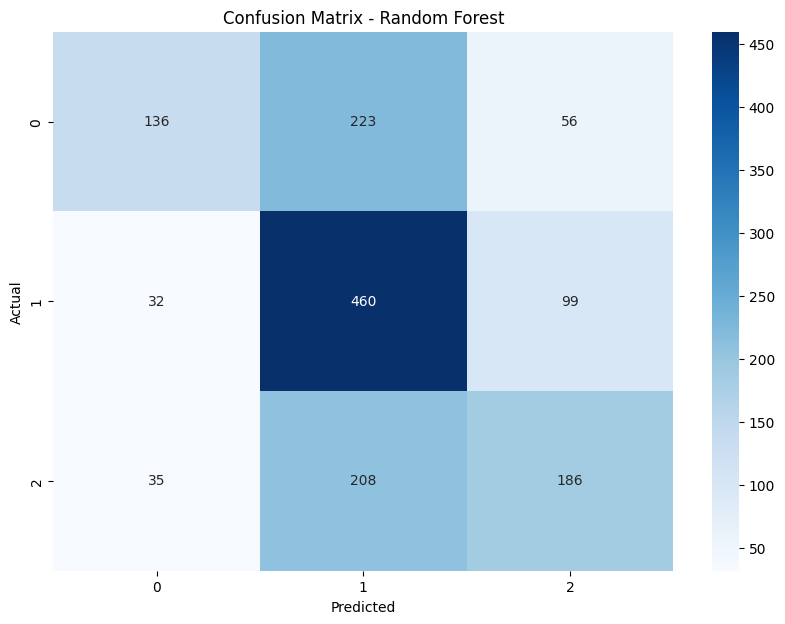

In [101]:
# Calculate confusion matrix for Random Forest predictions
cm_rf = confusion_matrix(y_val, rf_model.predict(X_val))

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

**Interpretasi**

Melalui confusion matrix di atas, diperoleh informasi bahwa model belum cukup baik dalam memprediksi masing-masing kelas. Dapat dilihat bahwa pada kelas 0 (actual), model lebih banyak memprediksi dalam kelas 1. Pada kelas 1, model sudah baik dalam memprediksi (True Positive). Sedangkan dalam kelas 2 (actual), model lebih banyak menggolongkan dalam kelas 1. Oleh karena itu, diperoleh informasi bahwa model cenderung memprediksi kelas 1 dengan benar, sedangkan yang lainnya kurang baik. Dengan nilai metrik akurasi sebesar 0.54 dan f1-score (macro) sebesar 0.51, model ini masih perlu ditinjau performanya dan dilakukan tindakan/modeling lain untuk memperoleh performa yang lebih baik. 

Hasil ini juga menunjukkan adanya indikasi overfitting yang tentunya perlu ditinjau lebih dalam untuk mengatasi permasalahan ini. 

### **Kesimpulan**

Melalui proses komputasi dengan menggunakan data train, diperoleh bahwa model terbaik, yakni model yang memiliki skor akurasi dan F-1 Score unggul adalah model random forest. Namun, saat model tersebut diaplikasikan pada data test (data baru), performa dari model tidak begitu kuat dan cenderung moderat. Dapat dilihat juga dari confusion matrix bahwa model cenderung memprediksi kelas 1 dengan benar dibandingkan dengan yang lainnya. Oleh karena itu, dapat dicurigai akan adanya overfitting pada model yang tentunya diperlukan adanya penanganan pada model.       